# Twitter user gender classification


In [1]:
% pylab inline
import pandas as pd
#import numpy as np
import matplotlib as plt
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import nltk
from nltk.corpus import stopwords 
import string
import heapq
import operator
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import SimpleRNN
from keras.layers import Dense, Dropout, Activation

import tweepy
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
import json
import os

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[nltk_data] Downloading package punkt to /home/oleg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/oleg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/oleg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Question 1
In this question we've preprocessed the data in our csv file and analyzed the given data.
We've printed out plots which indicates what are the most commonly used terms and hashtags used by the two opposite genders.

### explanation : 
we tried many ways to clean the text in the right manner to get maximal accuracy in the prediction stage.
one of the ways was to keep letters size (low,high) in the text that starts with '#' or '@' (with the function "lower" that we wrote in the functions cell).
the reason was because we thought man and women write the same words in different size letters when hashtaging them. 
after a few tries the results didn't differ much so we decided to lower all letters for the sake of smaller vocabullary in the bag of words and faster run time for the ANN (my computer crashed like 14 times lol).

### Functions for plot and text preprocessing

In [2]:
def lower(term):
    if term.startswith(('#','@')):
        return term
    else :
        return term.lower()

def clean(words_string):
    '''
    Returns a string after removing stop words and punctuations, lowering all characters and normalizing the words.
    '''
    terms=re.findall(r'('+'|'.join([letters_and_tags_without_numbers_str,emoticons_str])+')',words_string)
    
    stop = set(stopwords.words('english'))
    
    exclude=list(string.punctuation)
    exclude.append('rt')
    exclude.append('via')
    exclude=set(exclude)

    stop=stop.union(exclude)
    
    lemma = WordNetLemmatizer()
    terms=[lower(term) for term in terms]    
    stop_free=[i.lower() for i in terms if i not in stop]
    normalized = " ".join(lemma.lemmatize(term) for term in stop_free)
    return normalized

def uniteLists(list_of_lists_of_words):
    '''
    Doing flat reduce, returning only one list of strings 
    '''
    united=[]
    for list_of_words in list_of_lists_of_words:
        united+=list_of_words
    return united
def devideToTermsAndFreq(tfList):
    '''
    Returns all the terms and their frequencies in the given list.
    '''
    ans_terms=[]
    ans_freq=[]
    for key,val in tfList:
        ans_terms.append(key)
        ans_freq.append(val)
    return ans_terms,ans_freq

def createPlot(x_data,y_data,y_name,x_name,title,i,j,k,color,bartype):
    '''
    Prints a plot for the given inputs:
    x_data - an array for the x axes.
    y_data - an array for the y axes.
    y_name - the label for the y axes.
    x_name - the label for the x axes.
    title - title for the plot.
    i,j,k,color,bartype - some data for the decoration of the graph.
    '''
    axis_font = {'family': 'serif','color':  'black','weight': 'normal','size': 18,}
    title_font = {'family': 'serif','color':  'black','weight': 'normal','size': 22,}
    font_size=16
    df=pd.DataFrame(data={x_name:x_data,y_name:y_data})
    temp = df.pivot_table(values=y_name,index=x_data)
    temp.sort_values(by=(y_name), ascending=True,inplace=True)
    ax = fig.add_subplot(i,j,k) #121
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
    ax.set_xlabel(x_name,fontdict=axis_font)
    ax.set_ylabel(y_name,fontdict=axis_font)
    ax.set_title(title,fontdict=title_font)
    temp.plot(kind=bartype,ax=ax,cmap=color)

def findColDiff(df,col_name1,col_name2):
    return df[[col_name1,col_name2]][data_df[col_name1] != data_df[col_name2]]

def printNewCols(start,end):
    for i in range(start,end) :
        print(data_df.iloc[i]['text'])
        print(data_df.iloc[i]['clean_text'])
        print(data_df.iloc[i]['clean_words_list'])
        print(data_df.iloc[i]['hashtags'])
        print(data_df.iloc[i]['user_tag'])
        print()
def printCell(df,rowNum,colName):     
    print(data_df.loc[rowNum][colName])
    print(data_df.loc[rowNum][colName])
    print(data_df.loc[rowNum][colName])

### regular expressions for text filtering
those re help us to clean and filter the tweets.
we focused on few things :
- **urls**- almost all texts had urls that was meaningless for us in the concept of gender prediction.
- **emojies**- Although there weren't many emojies after few tries the predictions resulted better with them.
- **hashtags**- we separated and kept the '#' in the hashtags because after some tests the results was much better with the hashtags than without them. 
- **user_tags**- all words starting with '@'. like in hashtags, here we also kept the sign in the begining of the words because it had more impact on deciding the gender of the writer. for example boys may use the word justin in text but @justinbieber is more likely to be used by girls. 
- **letters_and_tags_str**- cleans the dirty text we don't want and keeps special words like fm.108
- **letters_and_tags_without_numbers_str** - in some stage of our work we decided to reduce the words from **letters_and_tags_str** to the same but without numbers and only words containig numbers in the middle of the word like "NBA2017". that gave us a slight improvment in the results maybe because many numbers in the bag of words caused overfitting.

In [3]:
emoticons_str = r"""(?:[:=;][oO\-]?[Dd\)\]\(\]/\\OpP])"""
html_str=r'<[^>]+>'
user_tags_str=r'(?:@[\w_]+)'
hashtags_str='#[a-zA-Z0-9]+'
url_str= r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
number_str= r'(?:(?:\d+,?)+(?:\.?\d+)?)'
another_str=r"(?:[a-zA-Z0-9#@][a-zA-Z0-9#@'\-_]+[a-zA-Z0-9#@])" # words with - and '
letters_and_tags_str='[a-z\'A-Z0-9#@][a-z\'A-Z0-9#@.-_]*'
letters_and_tags_without_numbers_str='[a-z\'A-Z#@][a-z\'A-Z0-9#@_-]*'

In [4]:
# Reading the data from the file
data_df=pd.read_csv('gender-classifier-DFE-791531.csv',header=0,encoding = 'latin1') #iso-8859-1

### cleaning the data

- **'text'**- sentence per user cleaned from http links and garbage letters.
- **'hashtag'**- list of #hashtags per user.
- **'user_tag'** - list of @user_tags per user.
- **'clean_text'**- same as 'text' just without #tags and @tags.
- **'clean_words_list'**- same as 'clean_text' just splitted to list of words per user.

In [5]:
def extractCleanedDataFromTweets(df):
    df = df[df['gender'].apply(lambda x : (x=='male' or x=='female') )]

    df['text']=df['text'].apply(lambda x :  re.sub(url_str,"",x))
    df['text']=df['text'].apply(clean)
    df['text']=df['text'].apply(lambda x :  re.sub('[\']+','',x))
    df['text']=df['text'].apply(lambda x :  re.sub('[\s]+',' ',x))

    df['emo']= df['text'].apply(lambda x : re.findall(emoticons_str,x))
    
    df['hashtags']=df['text'].apply(lambda x :  re.findall(hashtags_str,x))
    df['user_tag']=df['text'].apply(lambda x :  re.findall(user_tags_str,x))
    df['clean_text']=df['text'].apply(lambda x :  re.sub('[#@]\S+\s*',"",x))
    df['clean_words_list']=df['clean_text'].apply(lambda x:re.findall('[a-zA-Z0-9]+',x))
    return df

pd.options.mode.chained_assignment = None
data_df=extractCleanedDataFromTweets(data_df)

### Functions for the plots

In [6]:
def getTfByGender(data_df, gender):
    gender_words=uniteLists(data_df['clean_words_list'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(gender_words).most_common()
def getHashtagsByGender(data_df, gender):
    hashtag_words=uniteLists(data_df['hashtags'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(hashtag_words).most_common()
def getEmojiesByGender(data_df, gender):
    hashtag_words=uniteLists(data_df['emo'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(hashtag_words).most_common()

### male/female_tf contains is list of term:amount of appearnces for all terms per gender. 

In [7]:
male_tf = getTfByGender(data_df, 'male')
female_tf = getTfByGender(data_df, 'female')

### plot of the number of most common terms for male and female

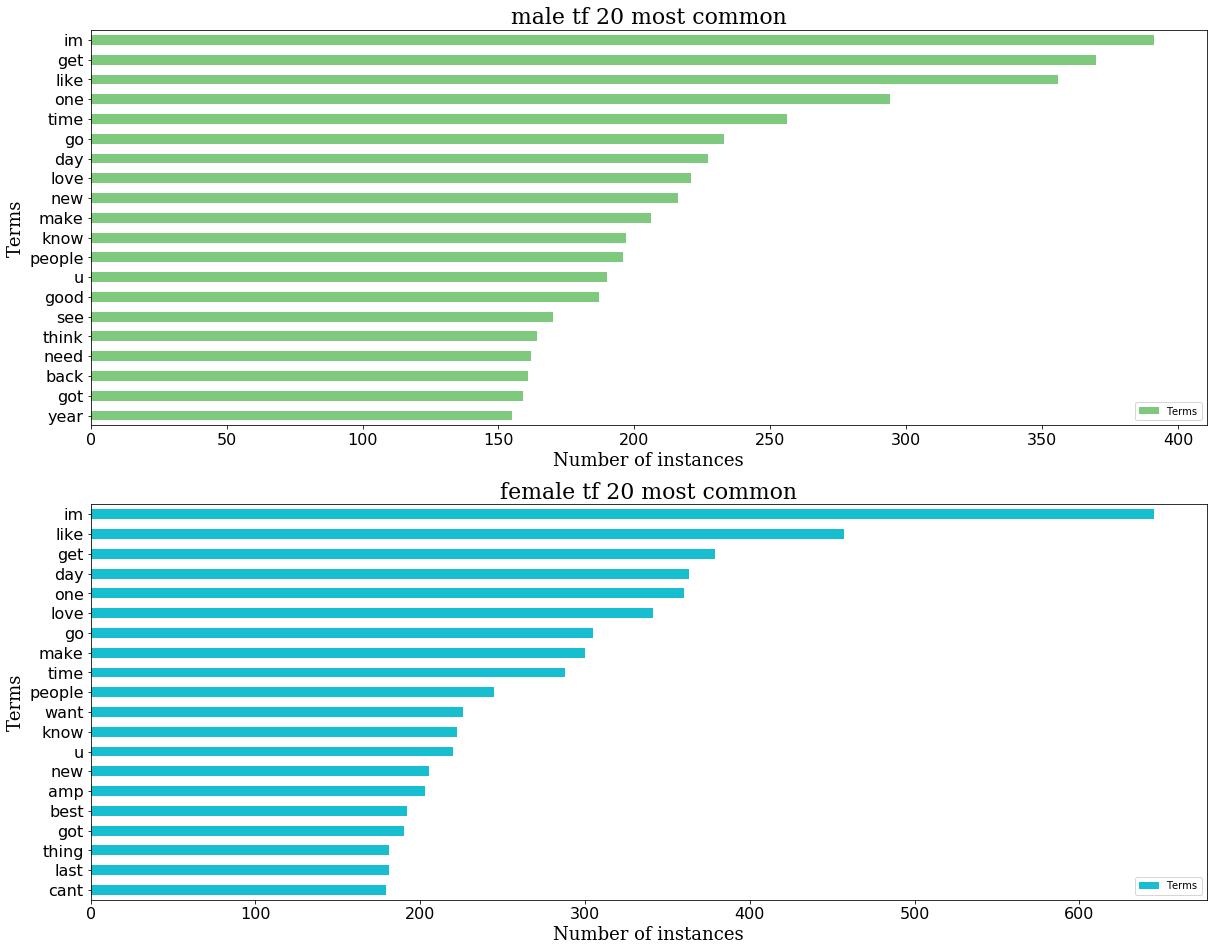

In [8]:
#pd.options.mode.chained_assignment
num=20
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common'%(num) ,2,1,1,'Accent','barh')
terms,freq=devideToTermsAndFreq(female_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common'%(num),2,1,2,'Vega10_r','barh')

### male/female_hashtag_tf contains all the hashtag:amount of appearnces per gender. 


In [9]:
male_hashtag_tf = getHashtagsByGender(data_df, 'male')
female_hashtag_tf = getHashtagsByGender(data_df, 'female')

### plot for num most common #hashtags

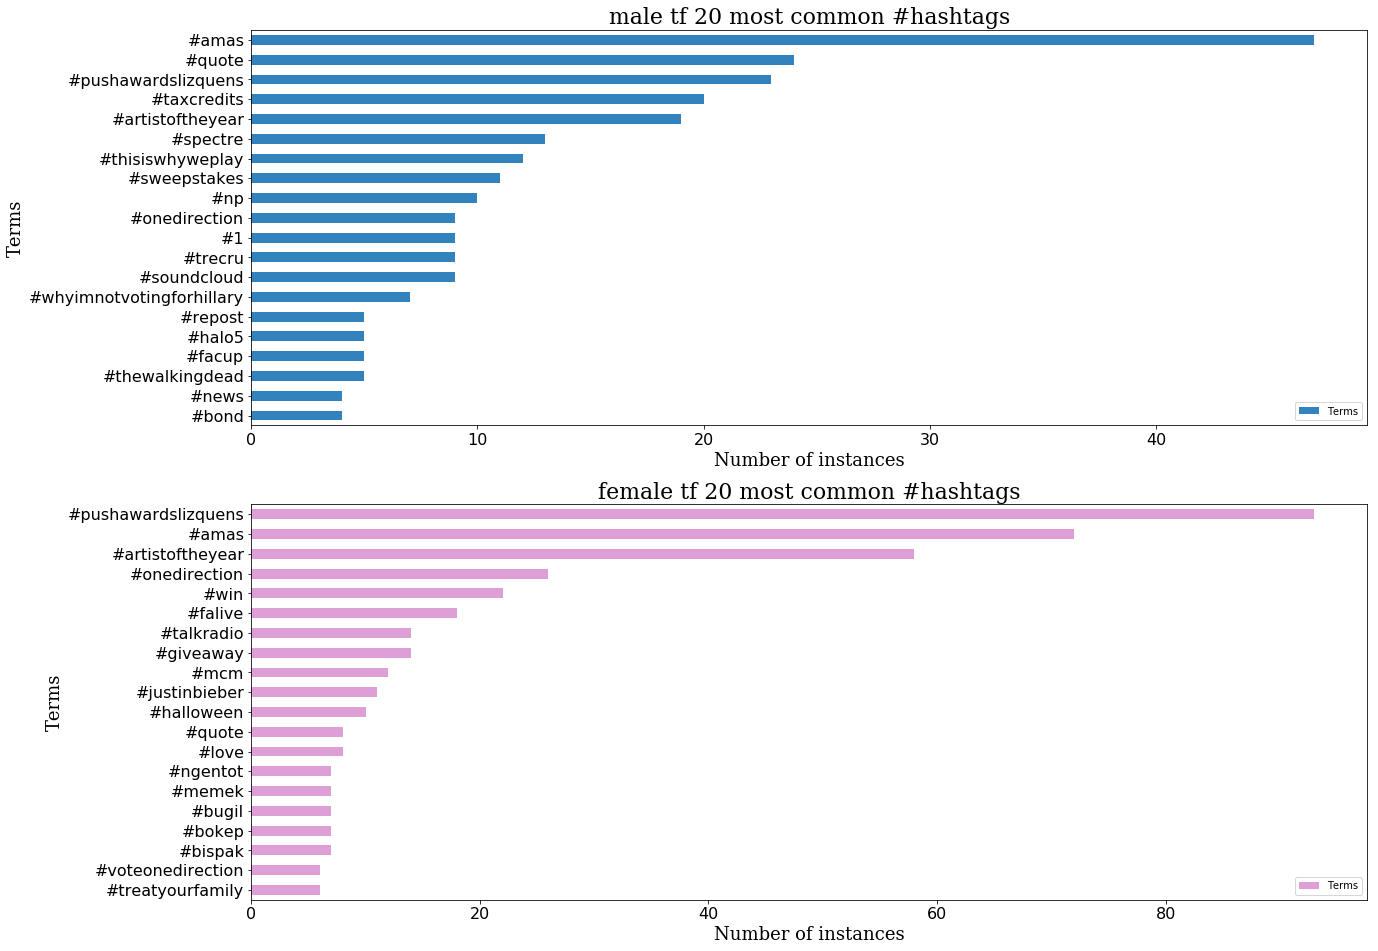

In [10]:
num=20
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common #hashtags'%(num),2,1,1,'Vega20c','barh')
terms,freq=devideToTermsAndFreq(female_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common #hashtags'%(num),2,1,2,'Vega20b_r','barh')

### male/female_emo_tf contains emojie: amount of apperances per gender. 

In [11]:
male_emo_tf = getEmojiesByGender(data_df,'male')
female_emo_tf=getEmojiesByGender(data_df,'female')

### plot for num most common emojies

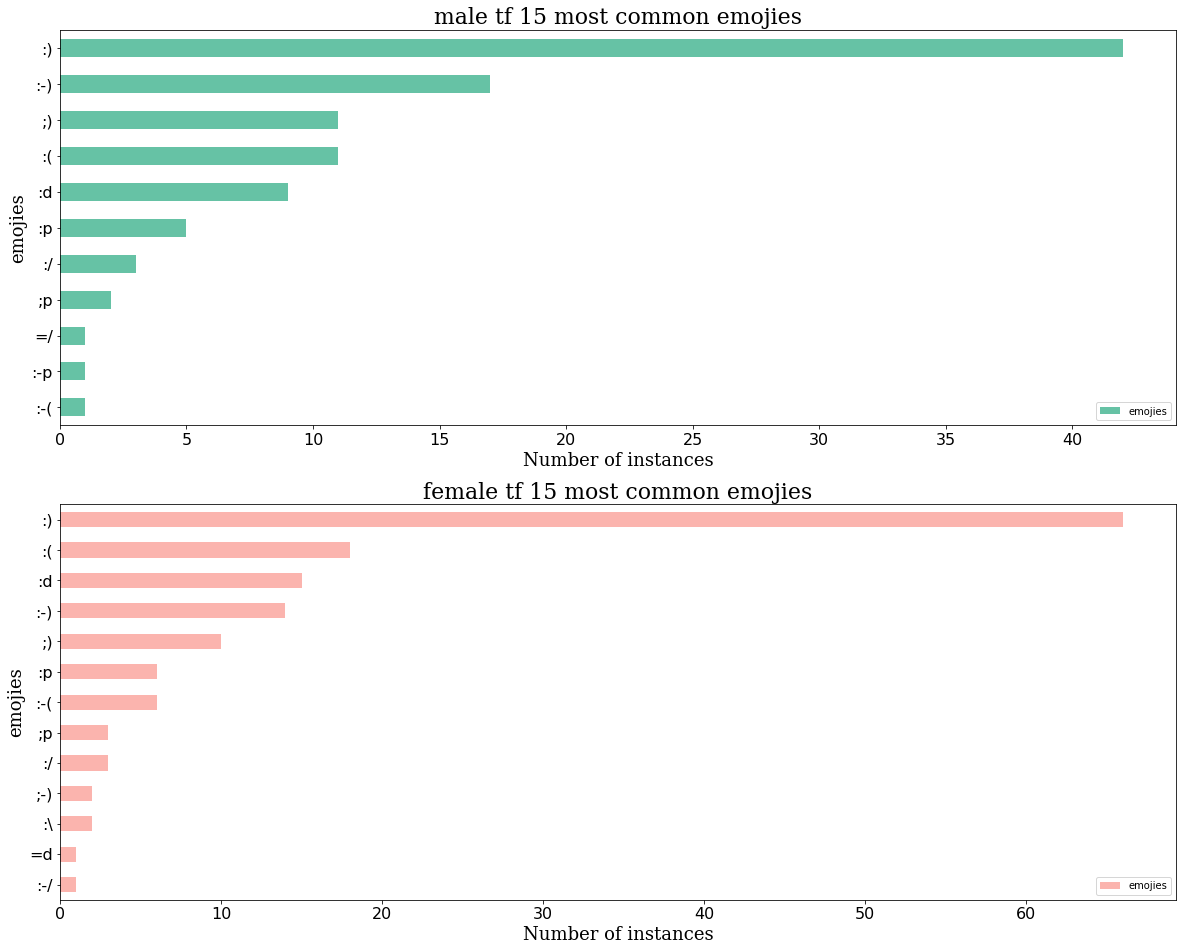

In [12]:
num=15
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_emo_tf)
createPlot(terms[:num],freq[:num],'emojies','Number of instances','male tf %s most common emojies'%(num),2,1,1,'Set2','barh')
terms,freq=devideToTermsAndFreq(female_emo_tf)
createPlot(terms[:num],freq[:num],'emojies','Number of instances','female tf %s most common emojies'%(num),2,1,2,'Pastel1','barh')

# Question 2
# Train a machine learning model to predict the gender of the tweet author

### functions for question 2
in the benchmark we used 2 accuracy tests -
1. cross validation with 5 groups - we calculated the mean of all accuracies we got for each validation.
2. the test - Y_test created latter.

In [13]:
#################################### change gender col in df from string to numeric and vice versa
def changeGenderToNum(word): 
    if word=='male':
        return 1 
    return 0
def changeNumToGender(num):
    if num==0:
        return 'female' 
    return 'male'
####################################

#################################### help us to run multiple classifiction algorithms easier.
def benchmark(clf,x_train,y_train,x_test,y_test): 
    print('_' * 80)
    print("Training: ")
    print(clf)
    scores = cross_val_score(clf, x_train, y_train, cv=5)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(x_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("CV accuracy:   %0.3f" % scores.mean())
    print("Y_test accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf,clf_descr, score, train_time, test_time

### buliding the bag of words representation
- **emojies_and_words_pattern** - is the pattern to keep emojies,hashtags and @ notations in the vocabulary
- **vectorizer** we tried CountVectorizer and TfidfVectorizer and gor higher results for the Tf-idf. in addition we had manny problems with the ann so we reduced the features number to 5000.
- **test_size** - is the sample size we take for the training and testing
- **ngram** - with the 1 gram we also used 2 gram vectorization to maintain in some matter the connection between words.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

data_df['num_gender']=data_df['gender'].apply(changeGenderToNum)

emojies_and_words_pattern='('+'|'.join([letters_and_tags_without_numbers_str,emoticons_str])+')'

#vectorizer = CountVectorizer(ngram_range=(1,2),lowercase=False,token_pattern=emojies_and_words_pattern)
vectorizer= TfidfVectorizer(ngram_range=(1,1),lowercase=False,token_pattern=emojies_and_words_pattern,max_features=10000)

test_size=10000

corpus_train=data_df['text'].tolist()[:test_size]
corpus_test=data_df['text'].tolist()[test_size:test_size*2]

vectorizer.fit(corpus_train)

X_train = vectorizer.transform(corpus_train)
Y_train = data_df['num_gender'][:test_size].tolist()

X_test = vectorizer.transform(corpus_test)
Y_test = data_df['num_gender'][test_size:test_size*2].tolist()

In [34]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

results = []

seed(123)
SVM1=SGDClassifier(max_iter=5)
SVM2=SGDClassifier(max_iter=1000)
SVM3=svm.LinearSVC()
NB1=MultinomialNB(alpha=1.0)
NB2=MultinomialNB(alpha=2.0)
KN1 =KNeighborsClassifier(n_neighbors=5)
KN2 =KNeighborsClassifier(n_neighbors=140)
RF1 = RandomForestClassifier(max_depth=5)
RF2 = RandomForestClassifier(max_depth=2000)
for clf, name in (
        (SVM1,"SVM1"),
        (SVM2,"SVM2"),
        (SVM3,"SVM3"),
        (NB1,"Naive Bayes 1"),
        (NB2,"Naive Bayes 2"),
        (KN1, "kneighbors 1"),
        (KN2, "kneighbors 2"),        
        (RF1,"Random Forest 1"),
        (RF2,"Random Forest 2")
    ):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf,X_train,Y_train,X_test,Y_test))

SVM1
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.007s
test time:  0.000s
CV accuracy:   0.585
Y_test accuracy:   0.606

SVM2
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.860s
test time:  0.000s
CV accuracy:   0.580
Y_test accuracy: 

In [16]:
X_train_Ann=X_train[:500].toarray()
Y_train_Ann=np.asarray(Y_train[0:500])
X_test_Ann=X_test[:500].toarray()
Y_test_Ann=np.asarray(Y_test[0:500])

In [17]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
seed(123)

model = Sequential()
model.add(Dense(X_train.shape[0], input_shape=(X_train.shape[1],), activation='sigmoid'))
model.add(Dense(X_train.shape[0], activation='sigmoid'))
model.add(Dense(X_train.shape[0], activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
# Fit the model
model.fit(X_train_Ann, Y_train_Ann, epochs=3, batch_size=50)

Epoch 1/3
500/500 [==============================] - 55s 110ms/step - loss: 0.3155 - acc: 0.5120
Epoch 2/3
500/500 [==============================] - 56s 111ms/step - loss: 0.3116 - acc: 0.5120
Epoch 3/3
500/500 [==============================] - 58s 116ms/step - loss: 0.3077 - acc: 0.5120


In [18]:
# evaluate the model
scores = model.evaluate(X_test_Ann, Y_test_Ann)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

500/500 [==============================] - 17s 34ms/step

acc: 43.40%


## Question 3

## Get most tweeted country
We've tried to find which country has the biggest number of tweets in our datasets,
as we can see, combining all the tweets from all the states of USA reveals that it is the most tweeted country.

In [19]:
locations = data_df['tweet_location'][data_df['tweet_location'].apply(lambda x: type(x) == str)]
locations=locations.apply(clean)
locations_tf = Counter(locations).most_common()

In [20]:
# Parameters and functionality initialization for our interaction with twitter api

consumer_key = 'aZgjP0NZeM4iiBaQXJcyOKLJB'
consumer_secret = 'VRLyop5JLP8Kh91CMnE0rpOKUhKEtrrVTCOozHVOd8QEFx69XX'
access_token = '326266960-9RZItG8Q4FUER0BOX4eO8mrvsvrrDWzaWiJqoens'
access_secret = 'v6UHn9puTUv5OgcDwGqf3UxfCZv6XSJZ1gB8UkXOFrnQo'

auth = OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)

api = tweepy.API(auth)

In [21]:
JSON_MALE_FILE_NAME='male_tweets.json'
JSON_FEMALE_FILE_NAME='female_tweets.json'
MAX_NUMBER_OF_TWEETS = 219
MALE_FILTER_HASHTAG = '#nba'
FEMALE_FILTER_HASHTAG = '#femalefilmmakerfriday'

class MyListener(StreamListener):
    def __init__(self, jsonFileName):
        self.jsonFileName = jsonFileName
        self.f = open(jsonFileName, 'w')
        self.f.write('[')
        self.tweets_gathered = 0
    
    def on_data(self, data):
    #def on_status(self, status):
        #global tweets_gathered
        if MAX_NUMBER_OF_TWEETS > self.tweets_gathered:
            self.tweets_gathered += 1
            try:
                print(self.tweets_gathered)
                self.f.write(data.rstrip() + ',')
                return True
            except BaseException as e:
                print("Error on_data: %s" % str(e))
            return True
        else:
            self.f.seek
            return False
    def on_error(self, status):
        print("Error" + status)
        return True
    def __del__(self):
        self.f.close()
        #just a fix to the json file
        with open(self.jsonFileName, 'rb+') as self.f:
            self.f.seek(-1, os.SEEK_END)
            self.f.write(b']')    
        print('died')
    def on_exception(self, exception):
        print(exception)

def generateTweets(isMalesGender):
    if isMalesGender:
        jsonFileName = JSON_MALE_FILE_NAME
        filterHashtags = MALE_FILTER_HASHTAG
    else:
        jsonFileName = JSON_FEMALE_FILE_NAME
        filterHashtags = FEMALE_FILTER_HASHTAG
    myList = MyListener(jsonFileName)
    twitter_stream = Stream(auth, myList)
    # I think Asi said she gives up on the location part because students told her it is somewhat problematic with the other fiter.
    # those coordinates are boxed that represents most of america - the country that we've found to have the most tweetings. 
    #twitter_stream.filter(locations=[-124.89,32.7,-93.07,48.99,
    #                                 -110.64,31.98,-84.43,47.01,
    #                                -99.04,26.29,-72.83,41.58,
    #                                -79.0,32.1,-70.6,43.69,
    #                                -75.3,41.06,-66.91,45.06])
    twitter_stream.filter(track=[filterHashtags])
     
# From here we generate the two json files, one for males a
#generateTweets(True)
#generateTweets(False)

In [22]:
new_twitts_male_df = pd.read_json(path_or_buf=JSON_MALE_FILE_NAME)
new_twitts_female_df = pd.read_json(path_or_buf=JSON_FEMALE_FILE_NAME)
new_twitts_male_df['gender'] = 'male'
new_twitts_female_df['gender'] = 'female'

new_twitts_df = new_twitts_male_df.append(new_twitts_female_df, ignore_index = True)

In [23]:
# fixes all the places part of the tweet was missing
for i in range(0, new_twitts_df.shape[0]):
    if pd.notnull(new_twitts_df.loc[i,'extended_tweet']):
        new_twitts_df['text'][i] = new_twitts_df['extended_tweet'][i]['full_text']

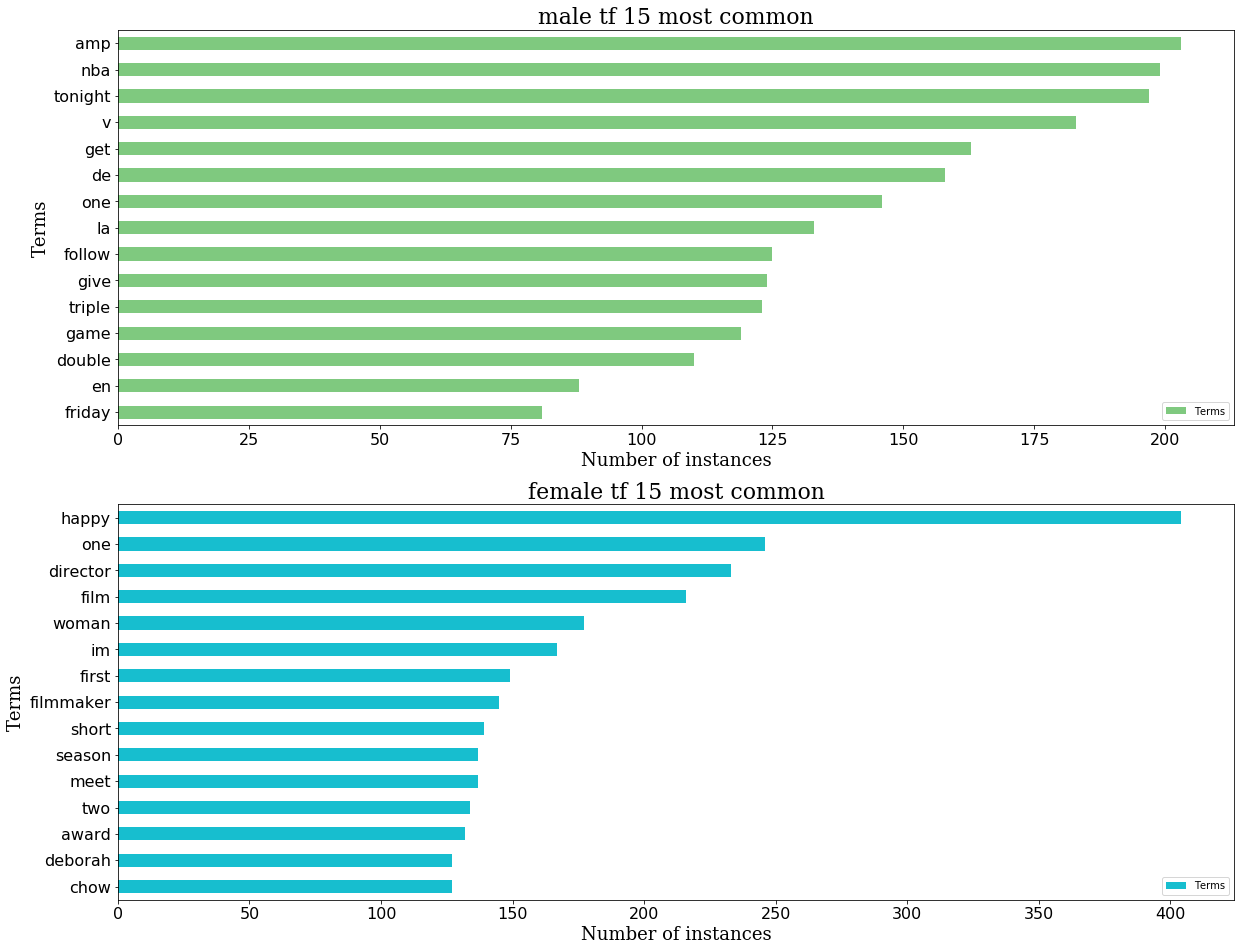

In [24]:
def removePairFromList(lst, el):
    for pair in lst:
        if pair[0] == el:
            lst.remove(pair)

new_twitts_df = extractCleanedDataFromTweets(new_twitts_df)
new_twitts_male_tf = getTfByGender(new_twitts_df, 'male')
new_twitts_female_tf = getTfByGender(new_twitts_df, 'female')
removePairFromList(new_twitts_male_tf, 'rt')
removePairFromList(new_twitts_female_tf, 'rt')

num=15
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(new_twitts_male_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common'%(num) ,2,1,1,'Accent','barh')
terms,freq=devideToTermsAndFreq(new_twitts_female_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common'%(num),2,1,2,'Vega10_r','barh')

### plot for num most common #hashtags

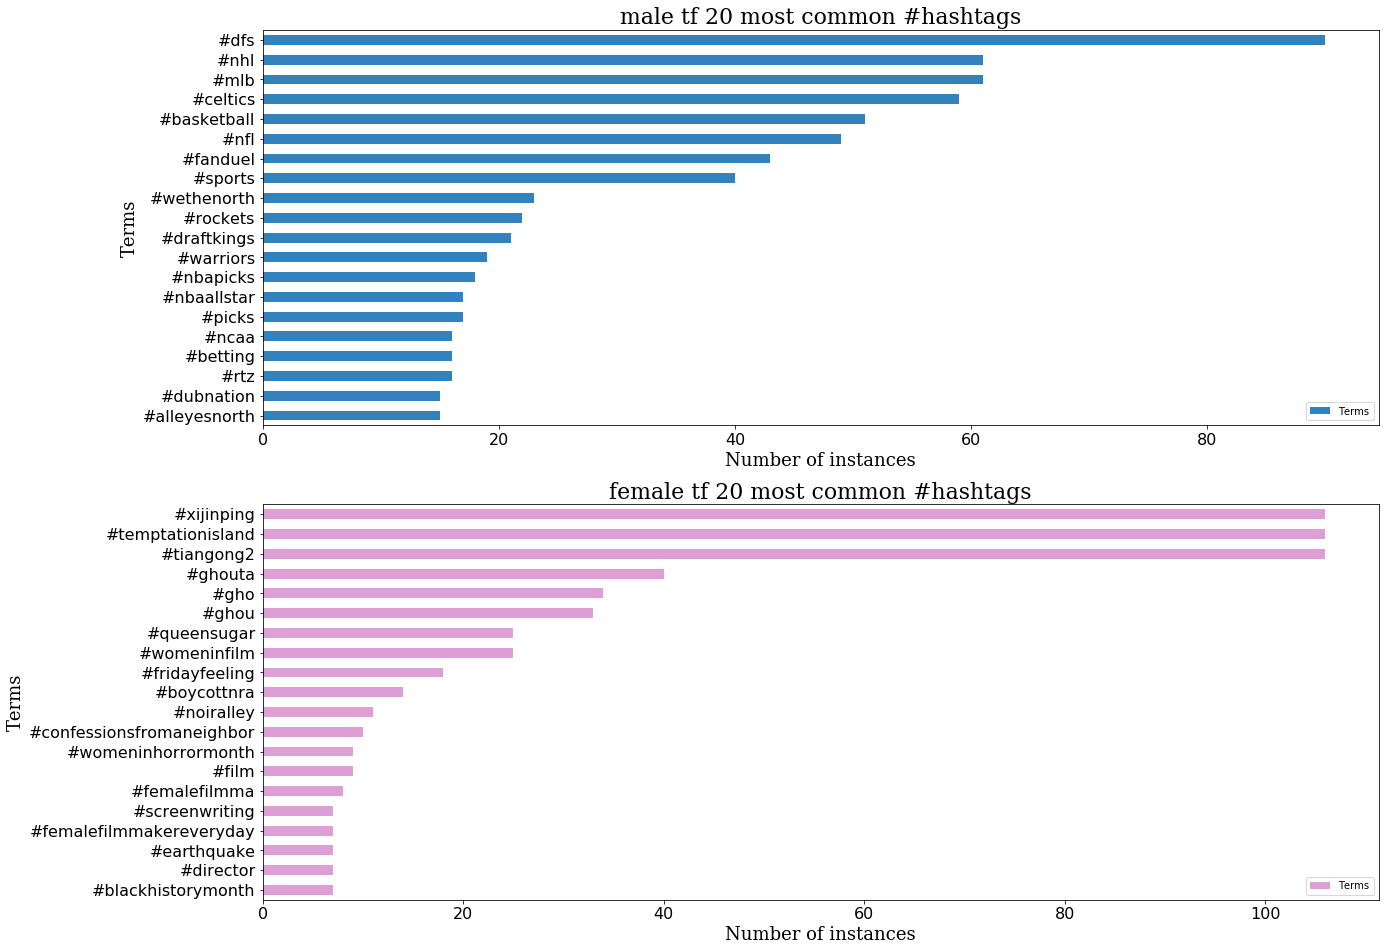

In [25]:
new_twitts_male_hashtag_tf = getHashtagsByGender(new_twitts_df, 'male')
new_twitts_female_hashtag_tf = getHashtagsByGender(new_twitts_df, 'female')
removePairFromList(new_twitts_male_hashtag_tf, '#NBA')
removePairFromList(new_twitts_male_hashtag_tf, '#nba')
removePairFromList(new_twitts_female_hashtag_tf, '#FemaleFilmmakerFriday')
removePairFromList(new_twitts_female_hashtag_tf, '#femalefilmmakerfriday')

num=20
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(new_twitts_male_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common #hashtags'%(num),2,1,1,'Vega20c','barh')
terms,freq=devideToTermsAndFreq(new_twitts_female_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common #hashtags'%(num),2,1,2,'Vega20b_r','barh')

### male/female_emo_tf contains emojie: amount of apperances per gender. 


In [26]:
new_twitts_male_emo_tf = getEmojiesByGender(new_twitts_df,'male')
new_twitts_female_emo_tf=getEmojiesByGender(new_twitts_df,'female')

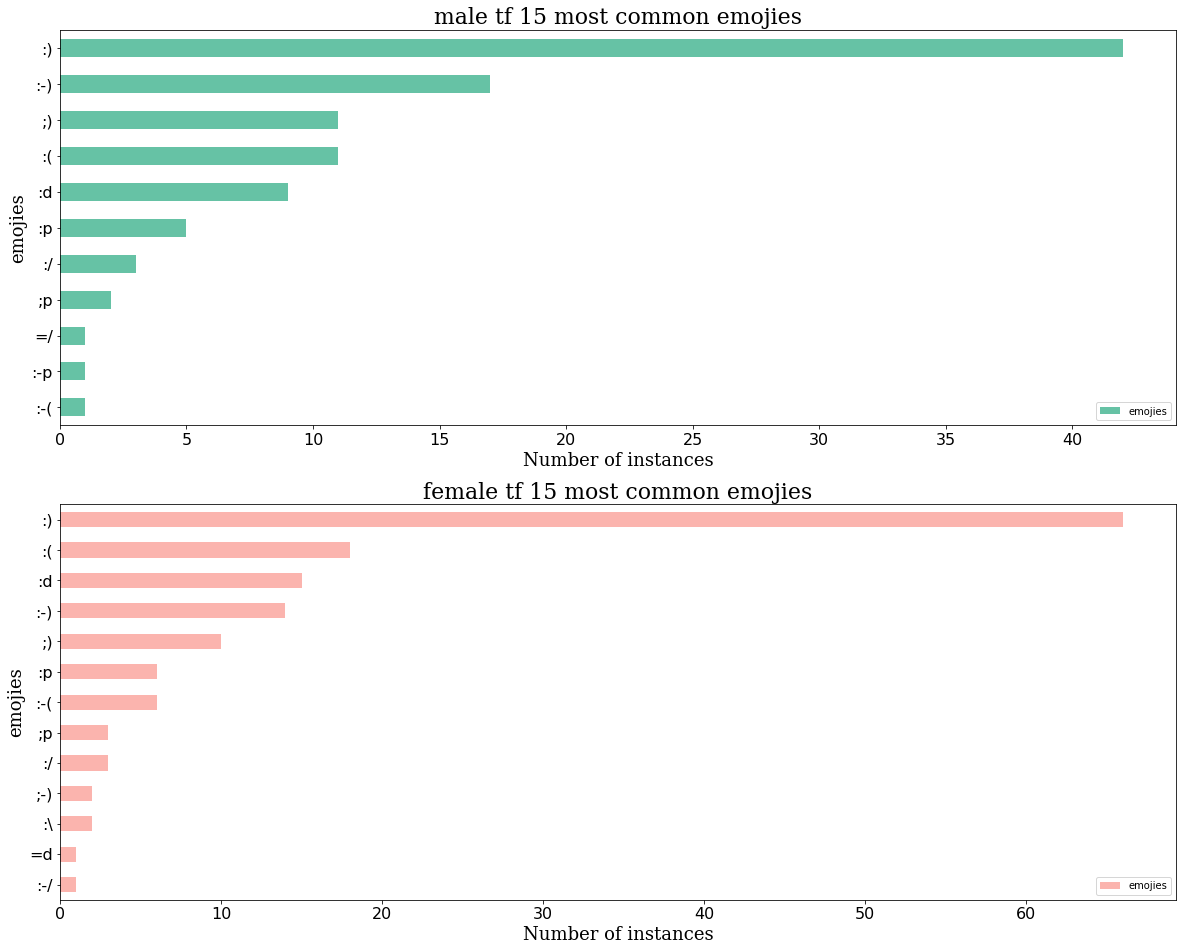

In [27]:
num=15
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_emo_tf)
createPlot(terms[:num],freq[:num],'emojies','Number of instances','male tf %s most common emojies'%(num),2,1,1,'Set2','barh')
terms,freq=devideToTermsAndFreq(female_emo_tf)
createPlot(terms[:num],freq[:num],'emojies','Number of instances','female tf %s most common emojies'%(num),2,1,2,'Pastel1','barh')

## Question 4

## time to test our work ... muahaha :)

### the new data has been cleaned and preprocessed in earlier question 3
### now we will build the corpus and transform the new data into vectors in bag of words representation

In [37]:
new_twitts_df['num_gender']=new_twitts_df['gender'].apply(changeGenderToNum)

new_test_size=1500

new_corpus_train=new_twitts_df['text'].tolist()[:new_test_size]
new_corpus_test=new_twitts_df['text'].tolist()[new_test_size:new_test_size*2]


new_X_train = vectorizer.transform(new_corpus_train)
new_Y_train = new_twitts_df['num_gender'][:new_test_size].tolist()

new_X_test = vectorizer.transform(new_corpus_test)
new_Y_test = new_twitts_df['num_gender'][new_test_size:new_test_size*2].tolist()

### clf is the classifier with the best accuracy score

In [38]:
max_score=0
for result in results:
    if (result[2]>max_score):
        best_algo=result
        max_score=result[2]

clf=best_algo[0]

### and here is our prediction ! :)

In [39]:
pred = clf.predict(new_X_test)
score = metrics.accuracy_score(new_Y_test, pred)
print("new_Y_test accuracy:   %0.3f" % score)

Y_test accuracy:   0.819


### now we will return to string representation 

In [41]:
gender_results=[]
for i in pred :
    gender_results.append(changeNumToGender(i))
    
gender_results

['female',
 'male',
 'male',
 'female',
 'female',
 'female',
 'female',
 'male',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'male',
 'female',
 'female',
 'female',
 'male',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'male',
 'female',
 'male',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'male',
 'female',
 'male',
 'female',
 'female',
 'female',
 'male',
 'female',
 'female',
 'male',
 'male',
 'female',
 'female',
 'male',
 'female',
 'female',
 'male',
 'male',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'male',
 'female',
 'female',
 'female',
 'female',
 'male',
 'female',
 'male',
 'male',
 'male',
 'male',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'female',
 'male',
 'female',
 'female',
 'female',